#### SAM2 on Databricks

To successfully run this notebook you must first create a new [Databricks Git Folder](https://docs.databricks.com/en/repos/index.html) configured with the SAM2 Github (https://github.com/facebookresearch/segment-anything-2) and import this notebook into the notebooks folder within the created Git folder `segment-anything-2/notebooks`. Paths in this notebook assume the correct location of the notebook within the repository.

You can now attach and run this notebook on a GPU enabled cluster

In [0]:
%sh pip install ../../segment-anything-2

#### Trigger sam2._C extension build

In [0]:
%sh cd ../ && python setup.py build_ext --inplace

#### Download model checkpoints

This will download all sizes. You can choose which checkpoint and configuration to use in the initialization later.

In [0]:
%sh cd ../checkpoints && ./download_ckpts.sh

In [0]:
%sh ls ../checkpoints

download_ckpts.sh
sam2_hiera_base_plus.pt
sam2_hiera_small.pt
sam2_hiera_tiny.pt


In [0]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [0]:
from sam2.build_sam import build_sam2_video_predictor
checkpoint = "../checkpoints/sam2_hiera_base_plus.pt"
model_cfg = "sam2_hiera_b+.yaml"
predictor = build_sam2_video_predictor(model_cfg, checkpoint)

/Workspace/Users/nick.karpov@databricks.com/segment-anything-2/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


#### pyplot based helpers for visualizing

In [0]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

#### Downloading the keynote from YouTube

Note: youtube may complain and you'll have to grab the video directly and upload into your Databricks environment

In [0]:
%pip install yt-dlp

In [0]:
%sh yt-dlp -o ./videos/keynote/keynote.mp4 -f "bestvideo[height<=480]" -u "username" -p "password" "https://www.youtube.com/watch?v=-6dt7eJ3cMs"

In [0]:
%sh ffmpeg -ss 00:00:15 -i ./videos/keynote/keynote.mp4 -t 00:00:10 -q:v 2 -start_number 0 /Volumes/sam/default/frames/'%05d.jpg'

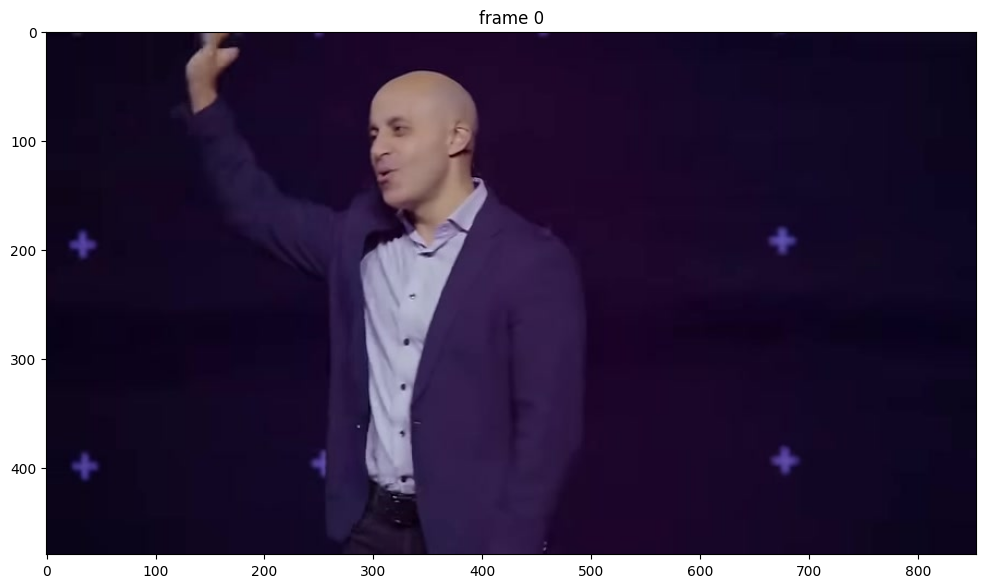

In [0]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "/Volumes/sam/default/frames"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(12, 8))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [0]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 300/300 [00:28<00:00, 10.55it/s]


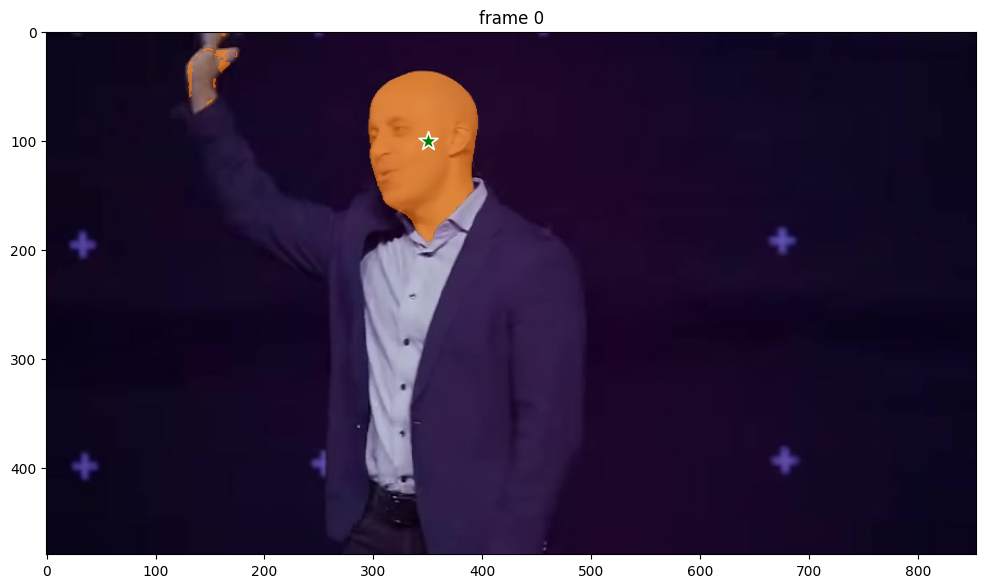

In [0]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[350, 100]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)

_, out_obj_ids, out_mask_logits = predictor.add_new_points(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(12, 8))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

In [0]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

propagate in video: 100%|██████████| 300/300 [02:53<00:00,  1.73it/s]


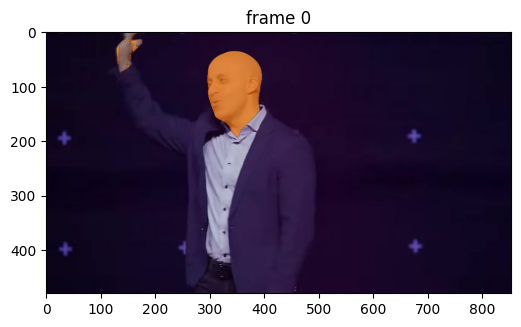

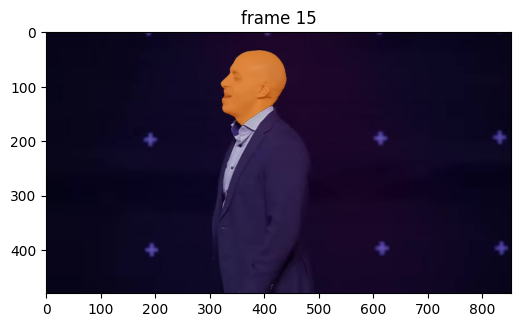

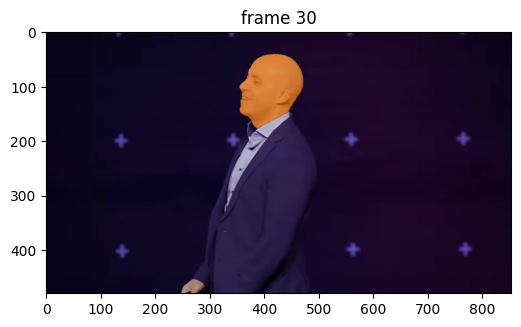

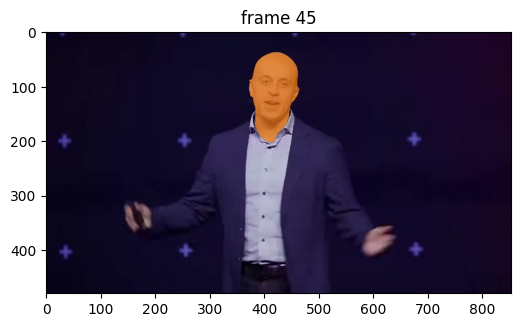

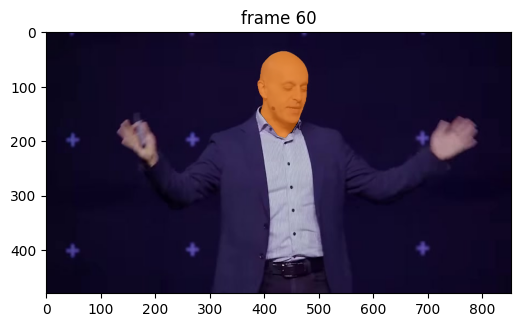

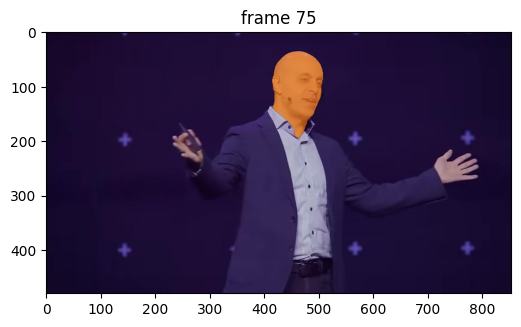

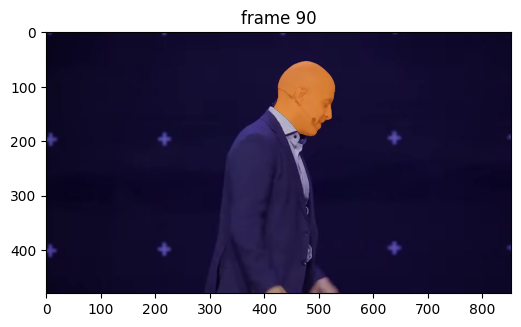

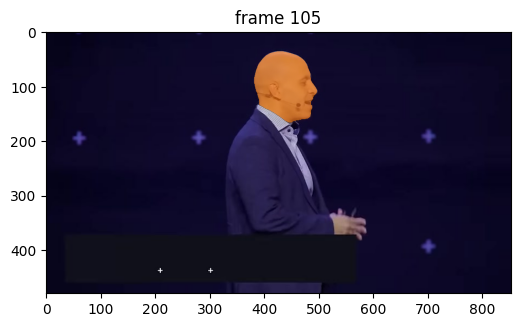

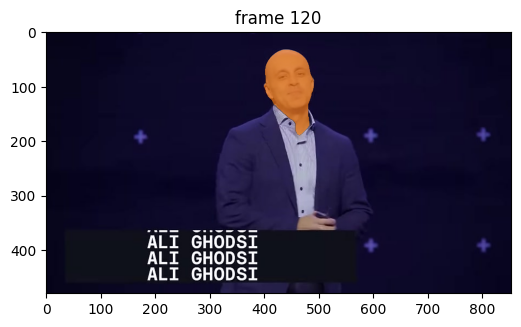

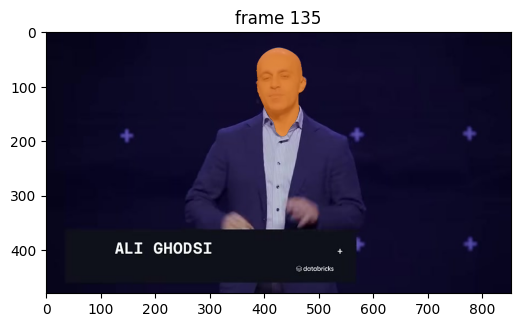

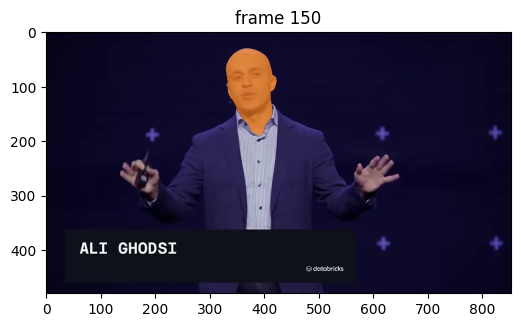

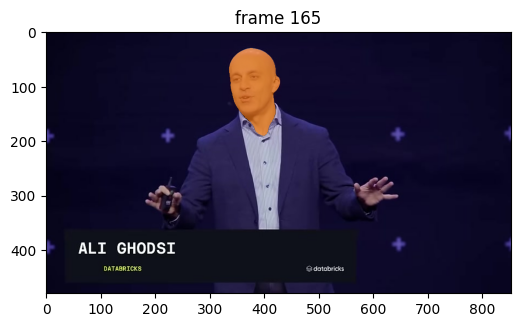

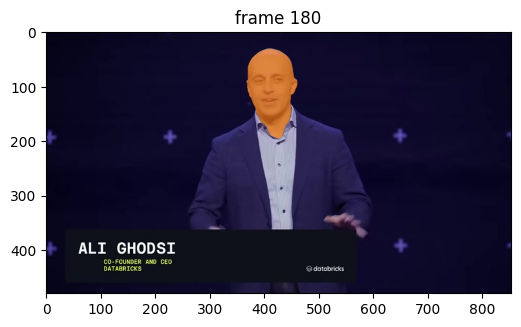

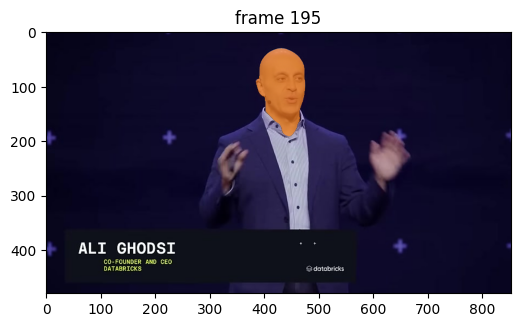

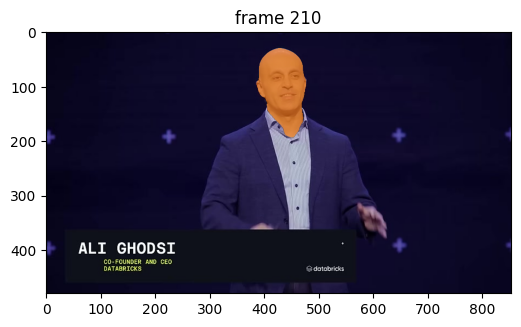

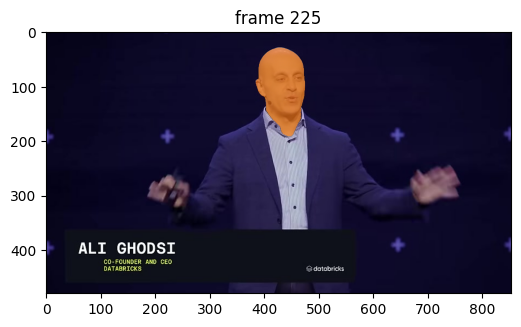

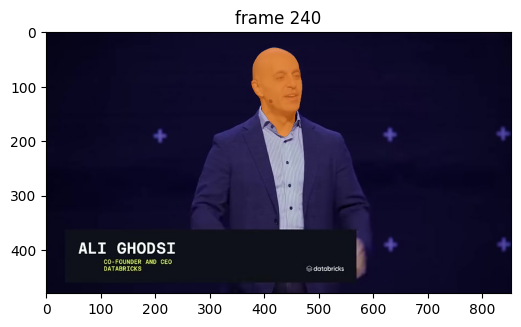

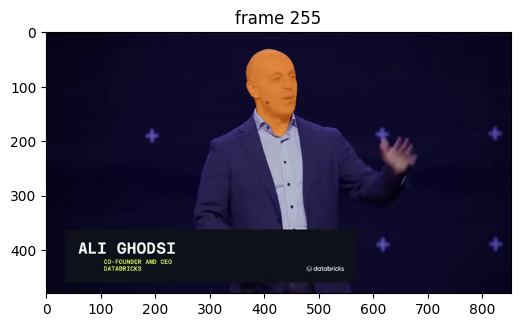

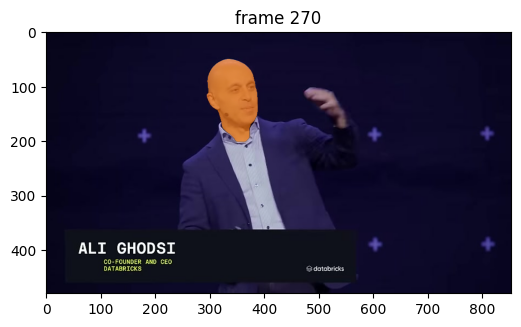

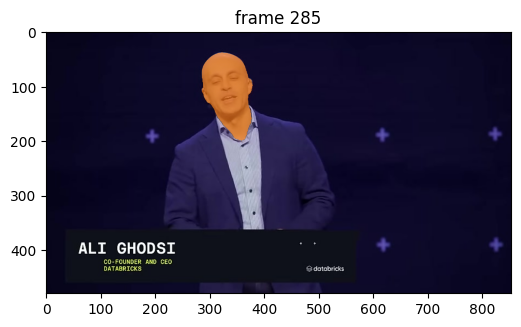

In [0]:
# render the segmentation results every few frames
vis_frame_stride = 15
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

#### IPython widget based slider

In [0]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

vis_frame_stride = 15

# Create an output widget to display the image
output = widgets.Output()

# Function to render a frame with segmentation results
def render_frame(out_frame_idx):
    with output:
        clear_output(wait=True)  # Clear only the output for the image, not the controls
        plt.figure(figsize=(6, 4))
        plt.title(f"frame {out_frame_idx}")
        plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
        for out_obj_id, out_mask in video_segments[out_frame_idx].items():
            show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
        plt.axis('off')
        plt.show()

# Callback function for slider and buttons
def update_frame(change):
    render_frame(change['new'])  # Call render_frame when slider value changes

# Initial frame to start
out_frame_idx = 0

# Create a slider for selecting frames
frame_slider = widgets.IntSlider(
    value=0, min=0, max=len(frame_names)-1, step=vis_frame_stride,
    description="Frame", continuous_update=False
)
frame_slider.observe(update_frame, names='value')

# Buttons for Previous and Next
def on_prev_clicked(b):
    if frame_slider.value > 0:
        frame_slider.value -= vis_frame_stride

def on_next_clicked(b):
    if frame_slider.value < len(frame_names) - 1:
        frame_slider.value += vis_frame_stride

prev_button = widgets.Button(description="Previous")
next_button = widgets.Button(description="Next")

prev_button.on_click(on_prev_clicked)
next_button.on_click(on_next_clicked)

# Display the controls and the output widget
controls = widgets.HBox([prev_button, frame_slider, next_button])
display(controls, output)

# Initial rendering of the first frame
render_frame(out_frame_idx)

Output()

#### Use Databricks displayHTML to build custom image `slider`

<!DOCTYPE html>
 
 
 
 Image Slider with Coordinates 
 
 
 
 
 ◀ 
 
 ▶ 
 Coordinates: (x, y)
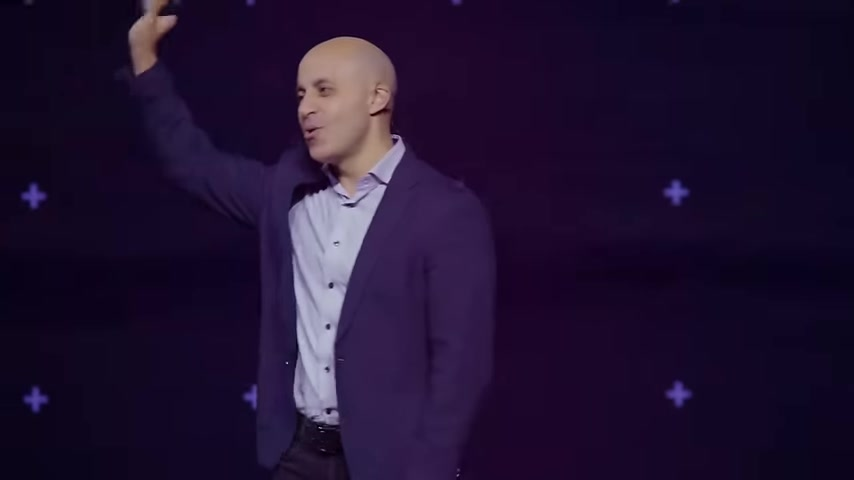
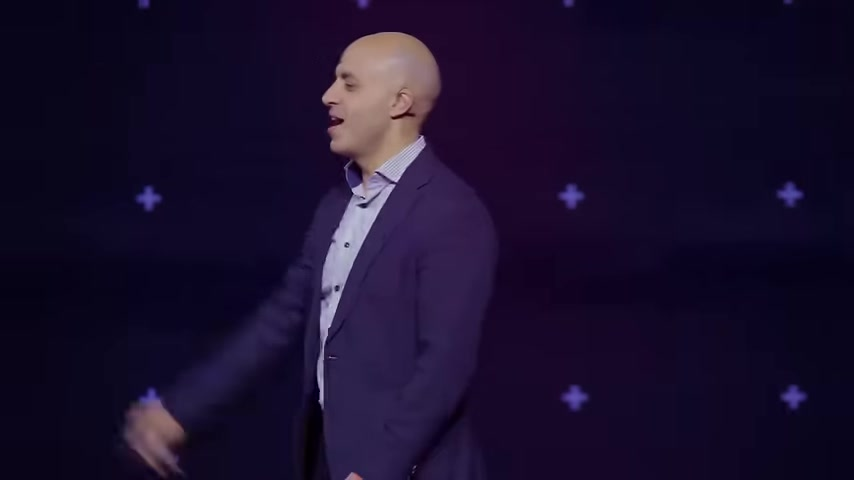
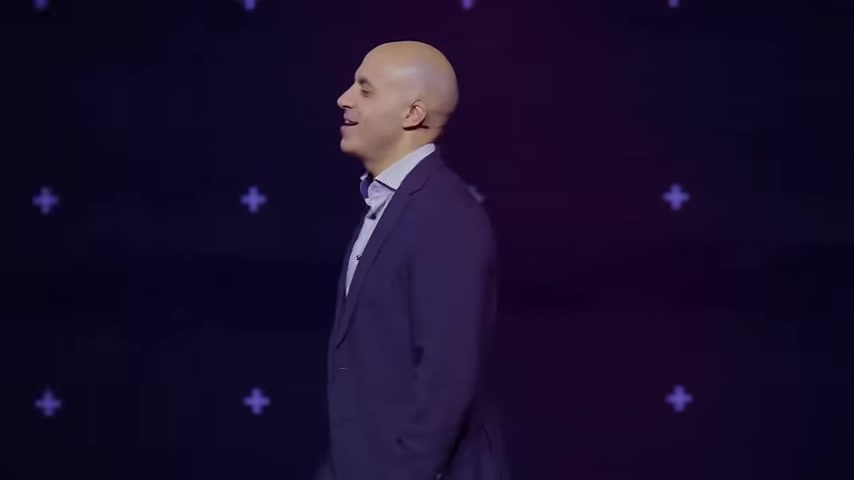
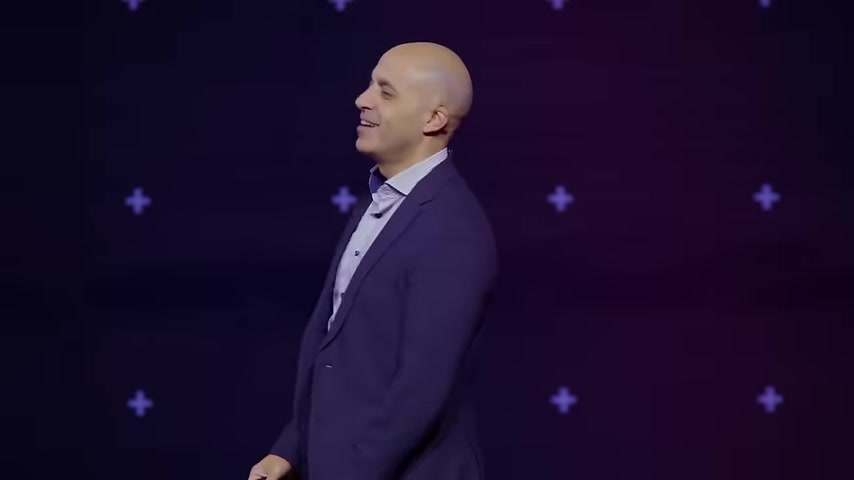
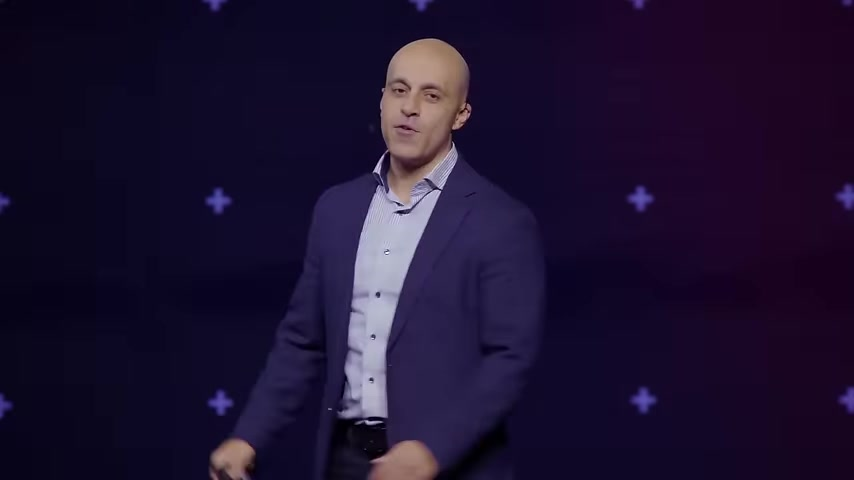
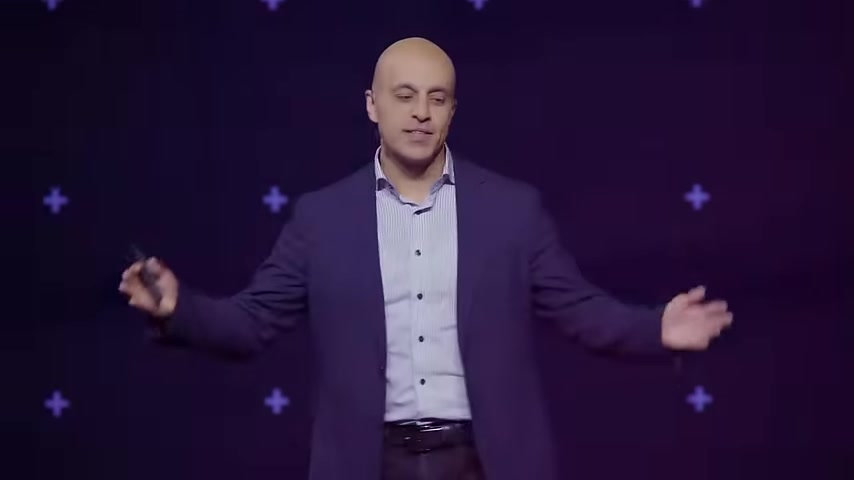
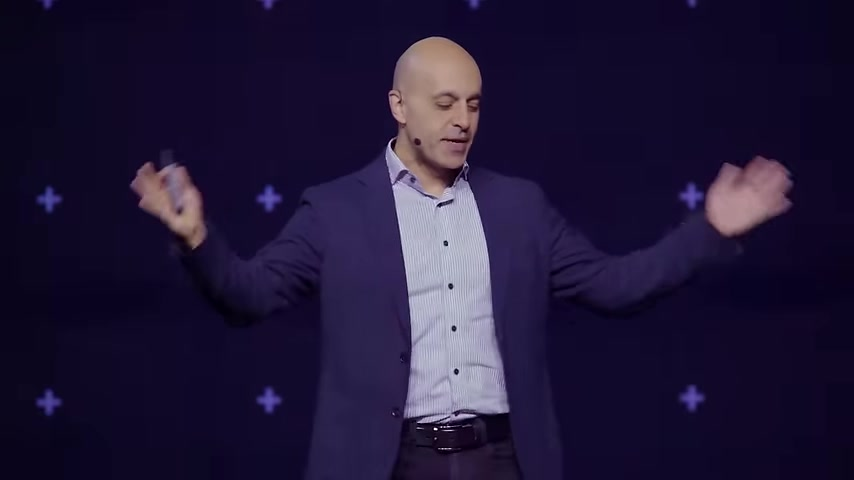
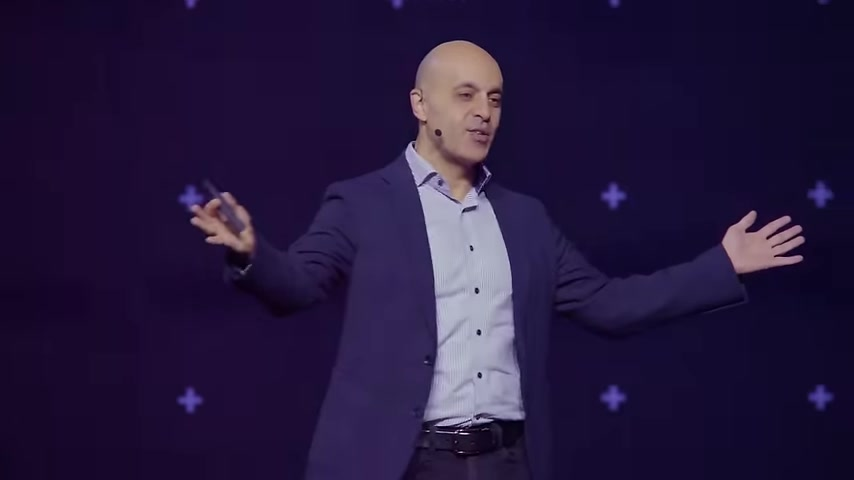
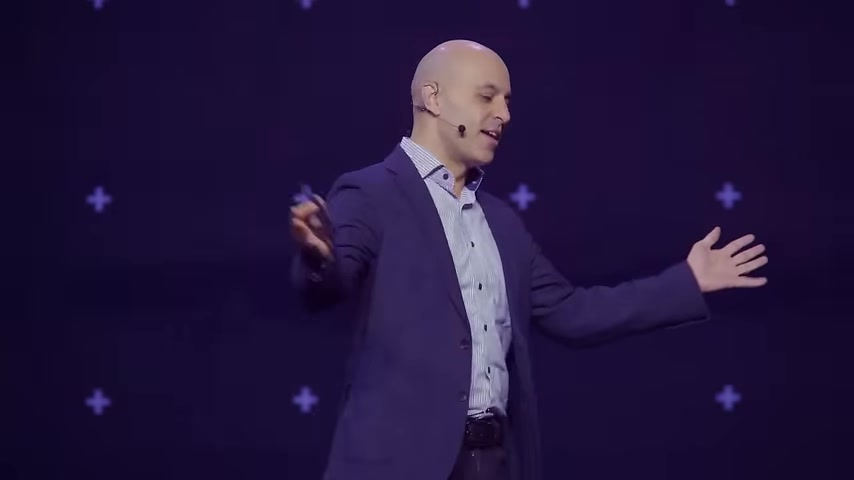
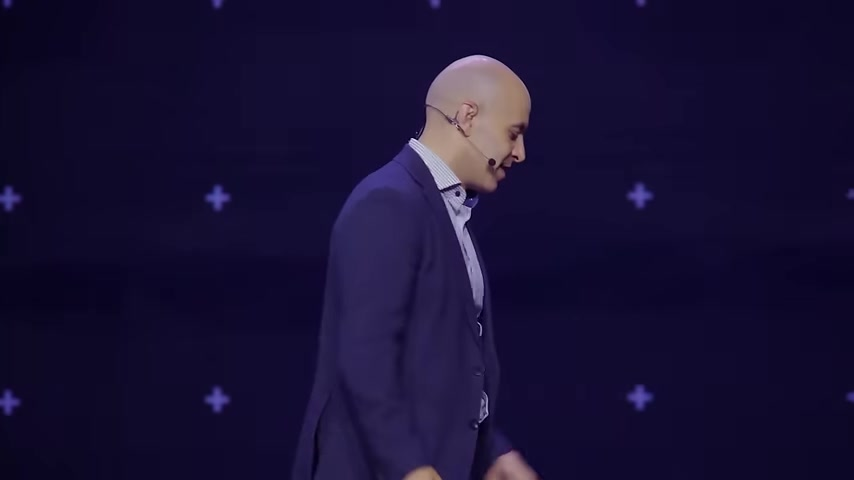
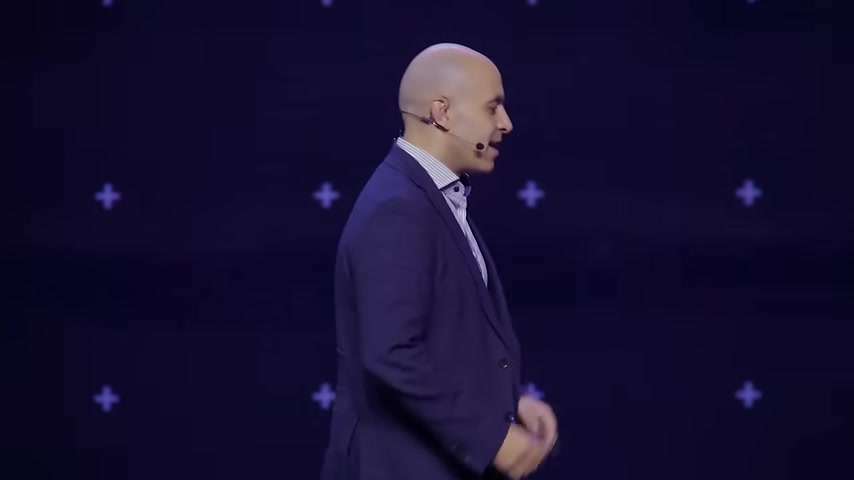
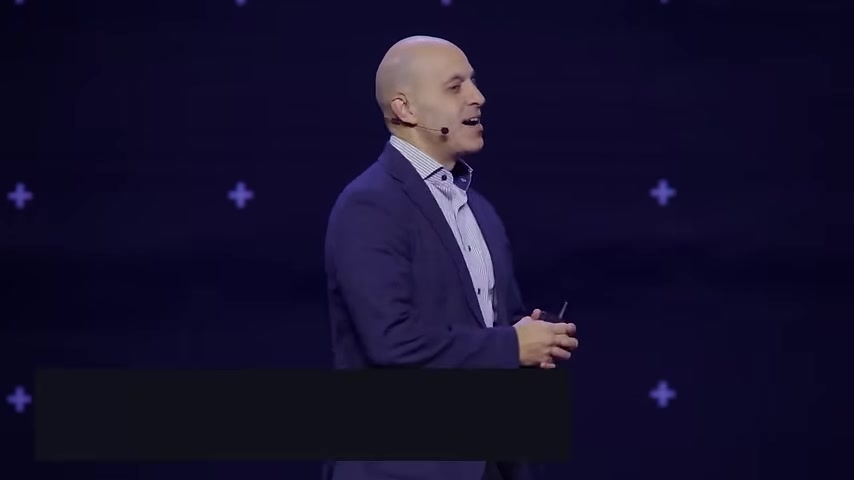
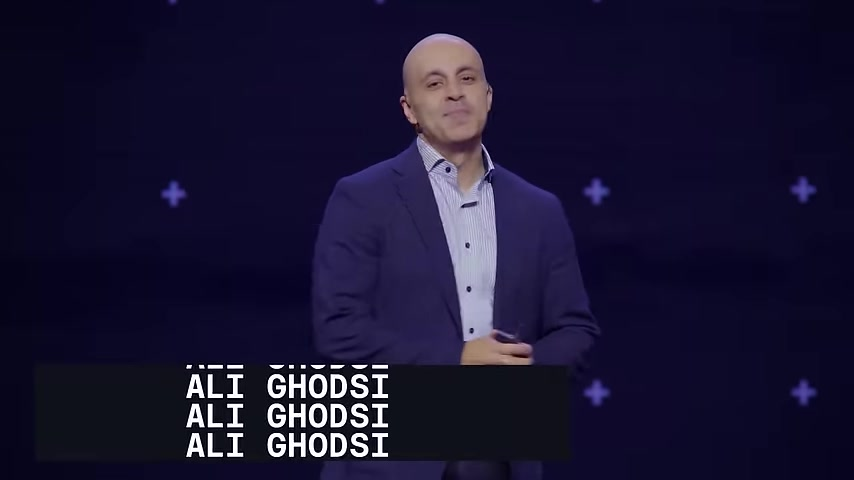
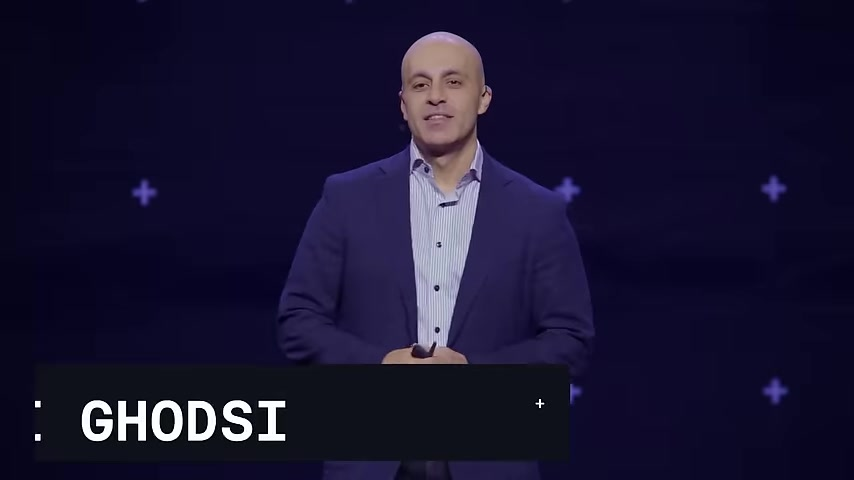
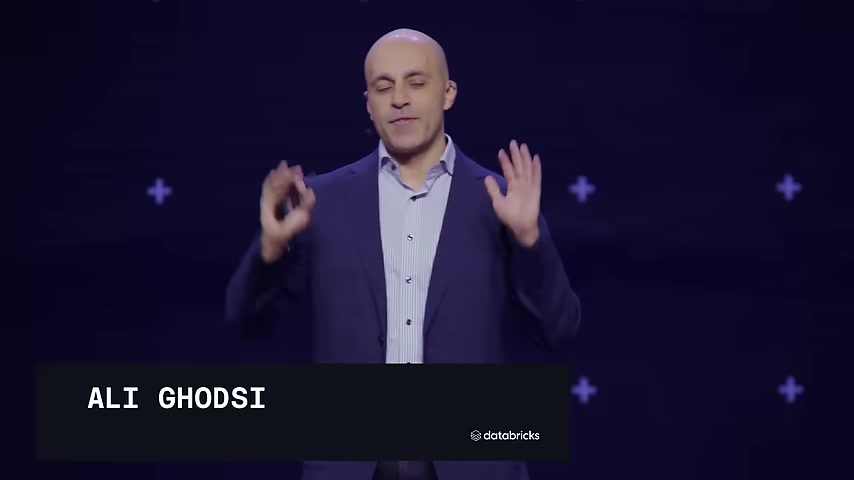
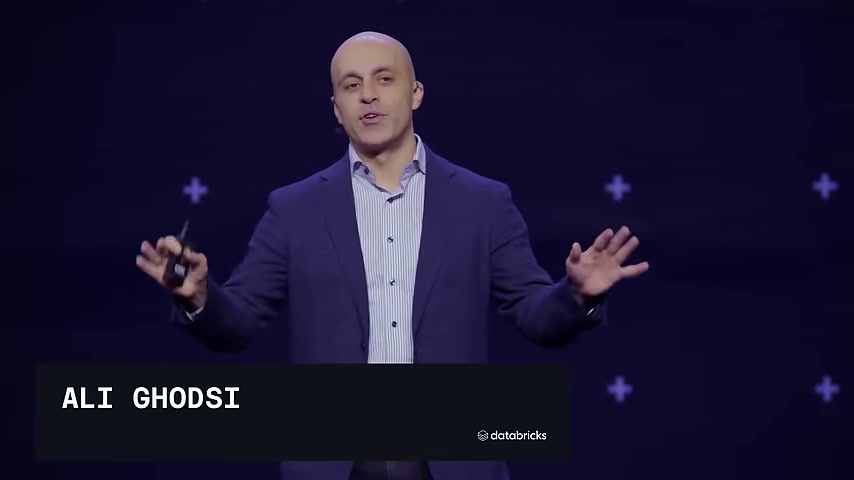
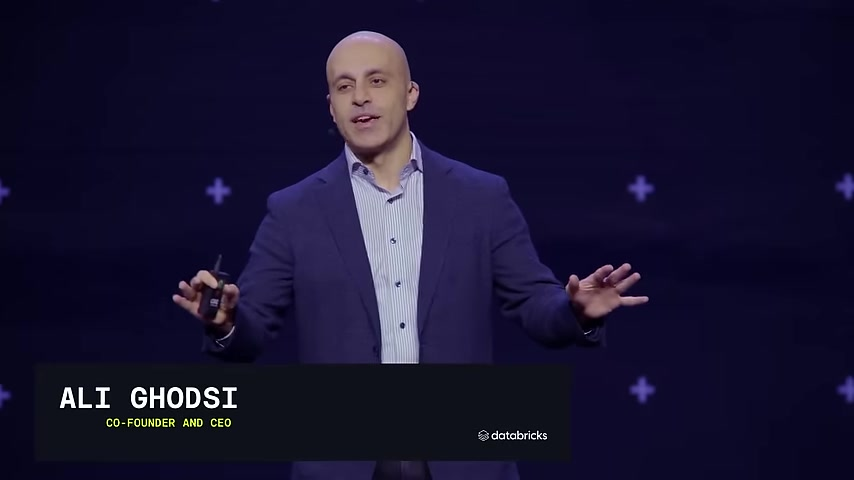
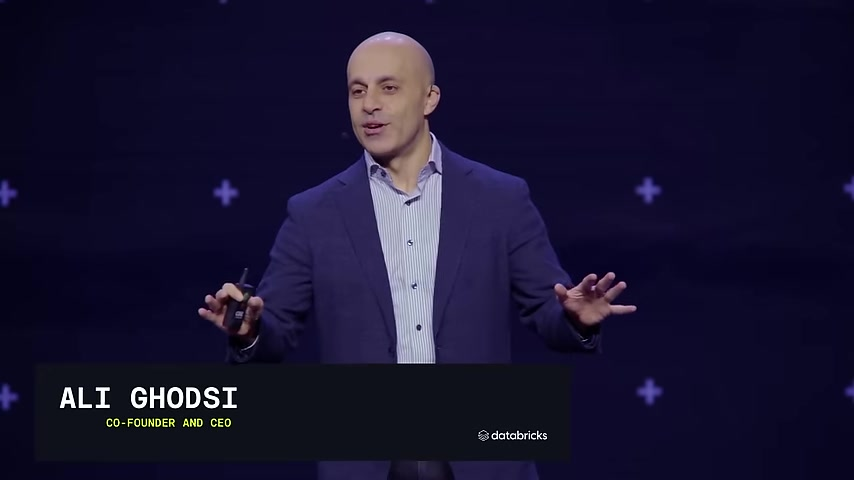
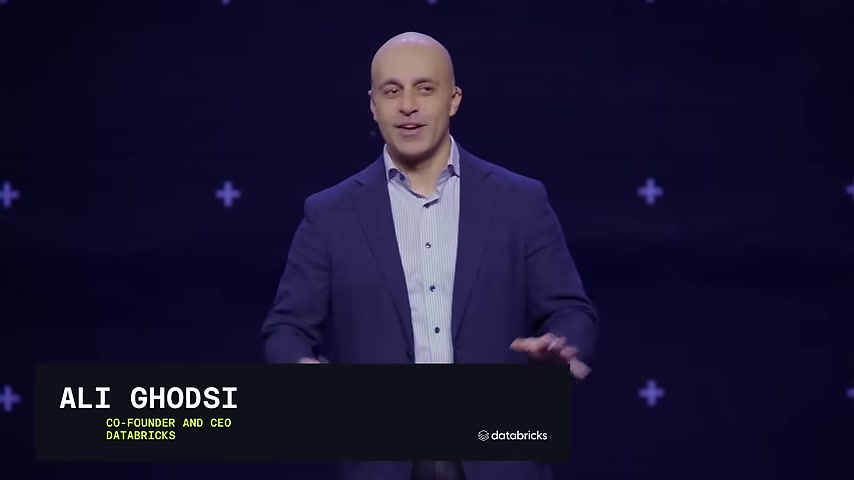
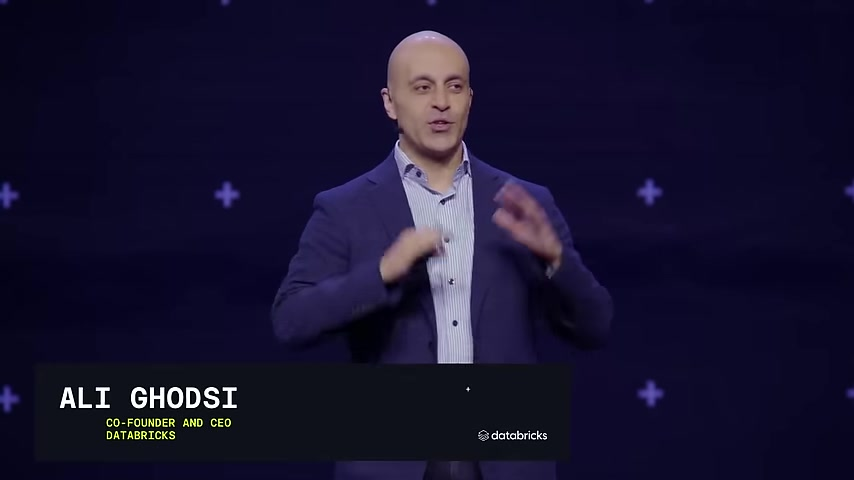
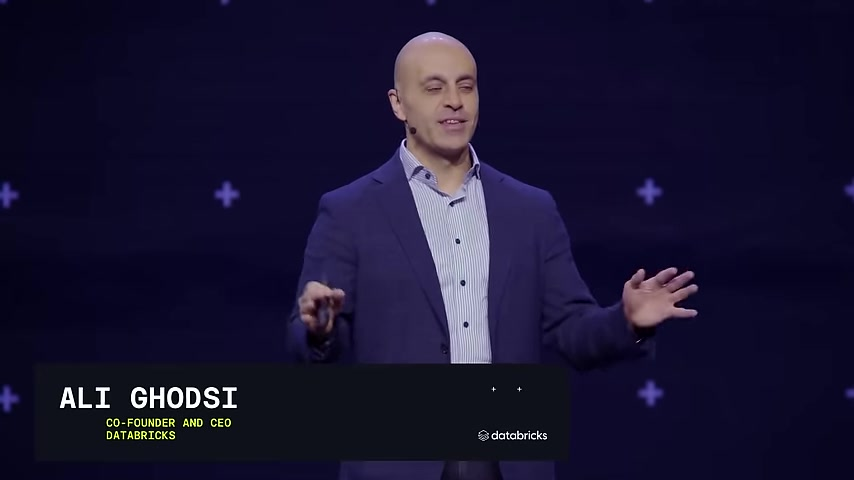
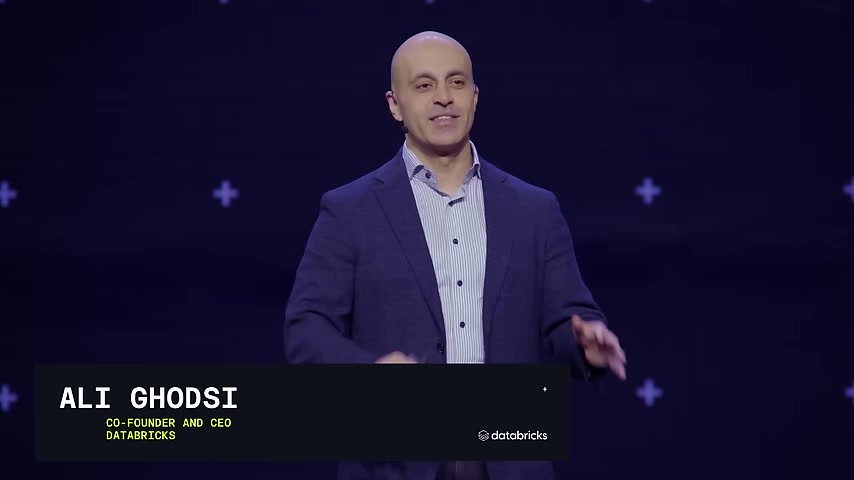
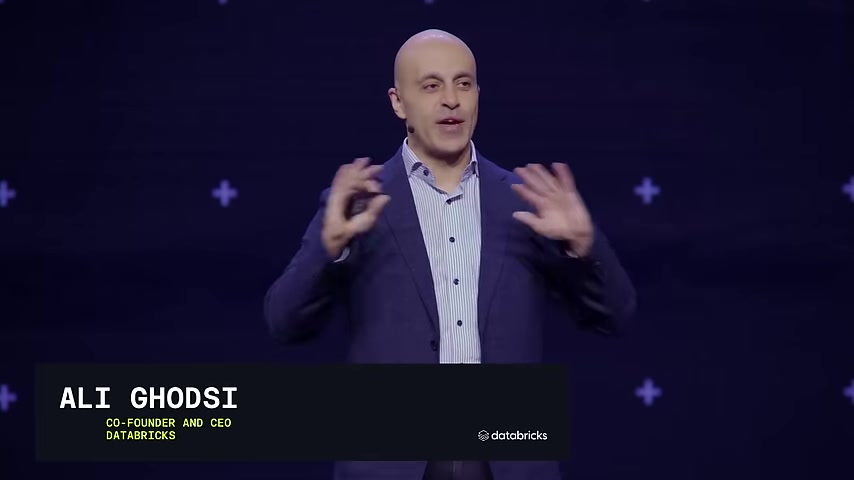
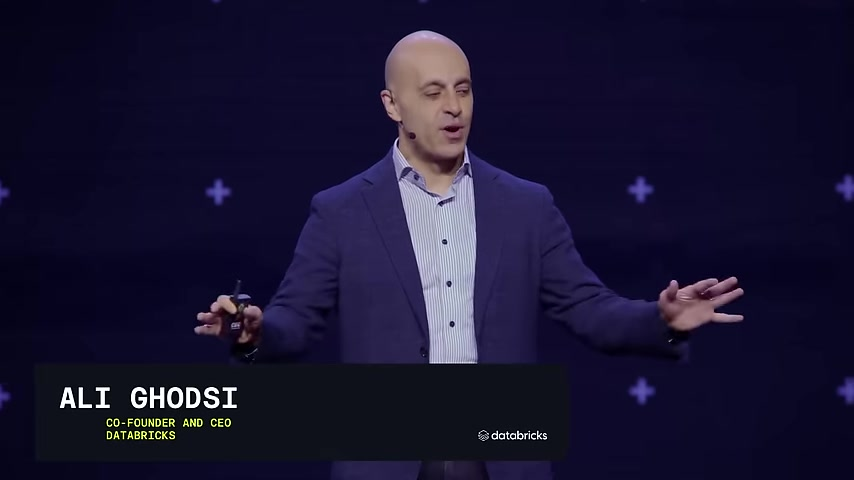
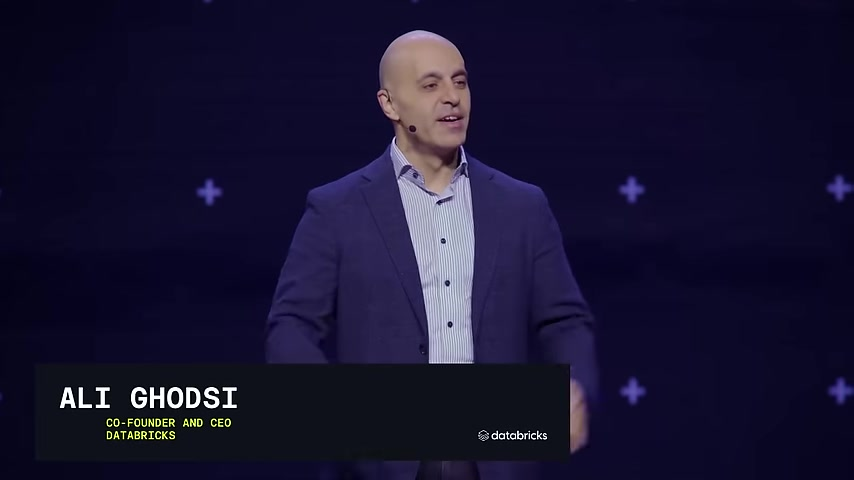
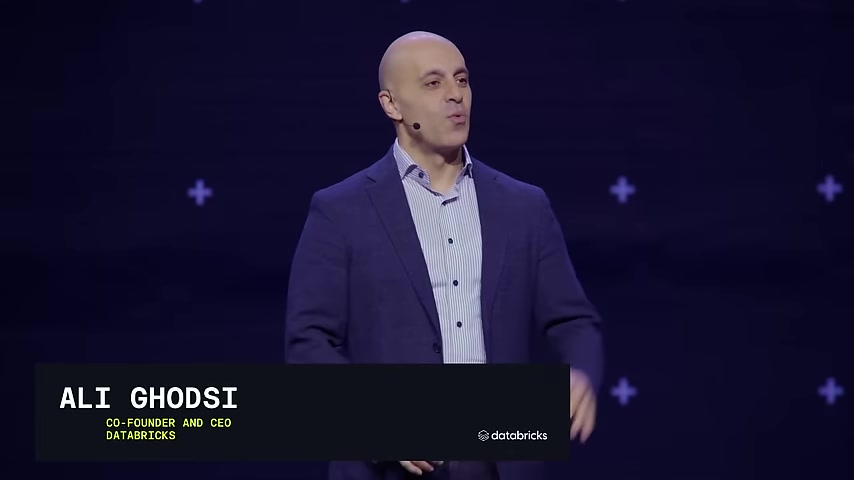
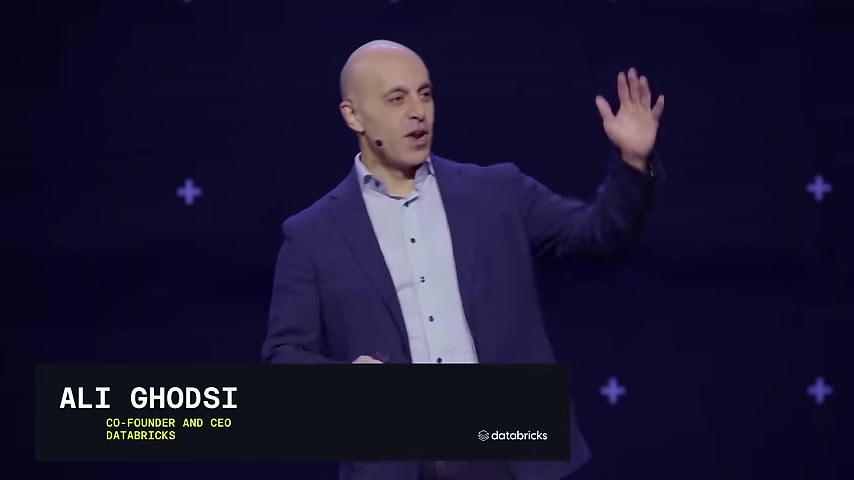
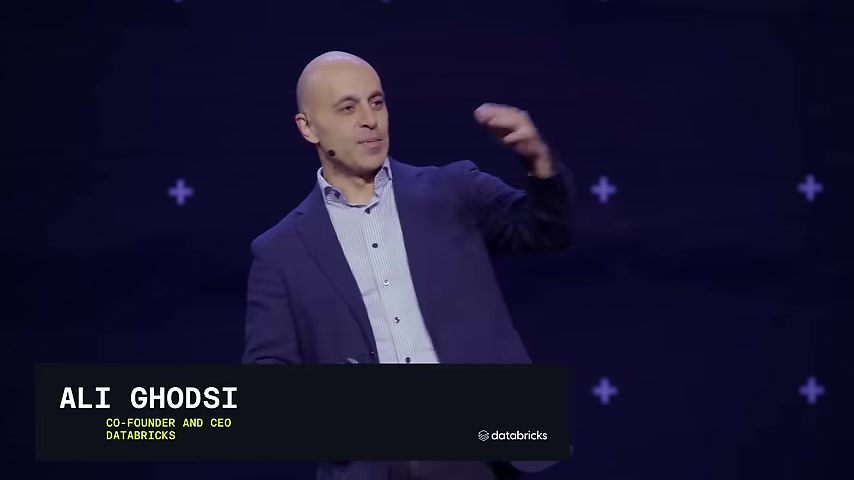
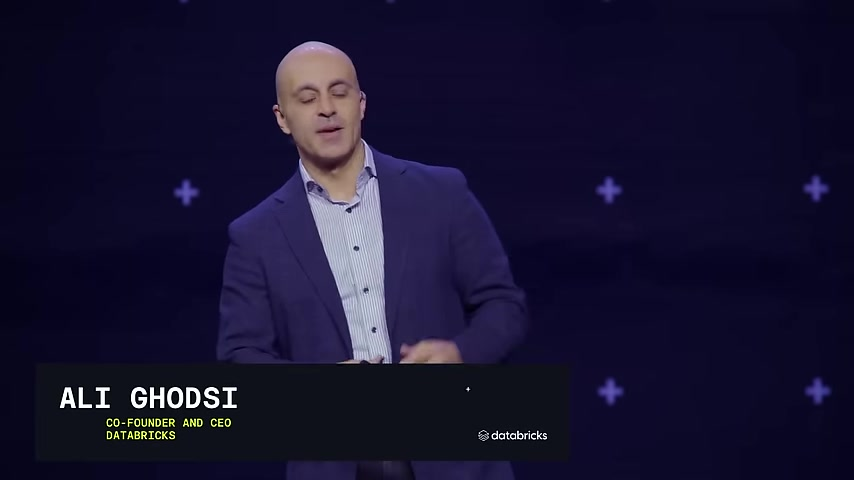
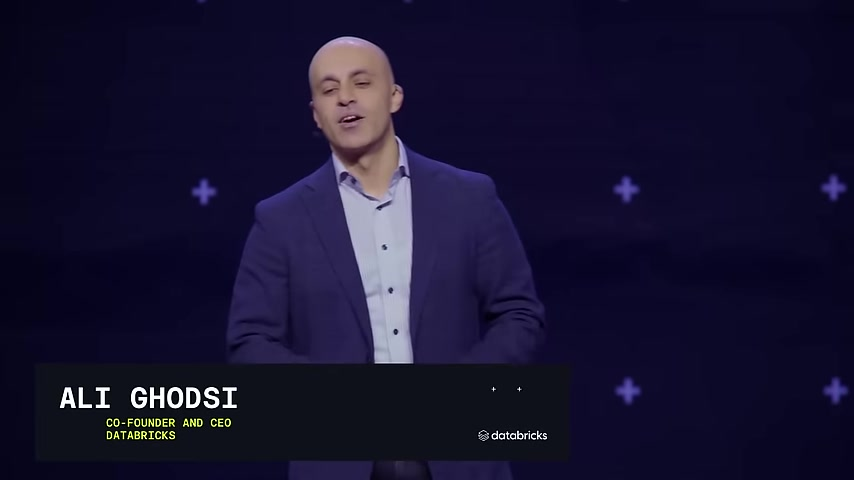

In [0]:
import os
import base64

def encode_image_to_base64(file_path):
    with open(file_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def process_images(directory):
    images = sorted([f for f in os.listdir(directory) if f.endswith('.jpg')])
    
    imgs = ""
    # Iterate through every 10th image starting with the first frame
    for i in range(0, len(images), 10):
        image_path = os.path.join(directory, images[i])
        imgs += f'"data:image/jpeg;base64,{encode_image_to_base64(image_path)}",'
    
    return imgs

imgs = process_images("/Volumes/sam/default/frames/")

html = f'''
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>Image Slider with Coordinates</title>
    <style>
        #slider-container {{
            width: 50%;
            margin: auto;
            text-align: center;
            position: relative;
        }}
        #image {{
            width: 100%;
            display: block;
        }}
        .nav-button {{
            position: absolute;
            top: 50%;
            transform: translateY(-50%);
            background-color: rgba(255, 255, 255, 0.5);
            border: none;
            font-size: 2em;
            cursor: pointer;
        }}
        #prev {{
            left: 0;
        }}
        #next {{
            right: 0;
        }}
        #coords {{
            position: absolute;
            top: 10px;
            left: 10px;
            background: white;
            padding: 5px;
        }}
    </style>
</head>
<body>
    <div id="slider-container">
        <button id="prev" class="nav-button">&#9664;</button>
        <img id="image" src="" alt="Image Slider">
        <button id="next" class="nav-button">&#9654;</button>
        <div id="coords">Coordinates: (x, y)</div>
    </div>
    <script>
        let images = [
            {imgs}
        ];
        
        let currentIndex = 0;
        let imgElement = document.getElementById('image');
        let prevButton = document.getElementById('prev');
        let nextButton = document.getElementById('next');
        let coords = document.getElementById('coords');

        function showImage(index) {{
            imgElement.src = images[index];
        }}

        prevButton.addEventListener('click', () => {{
            currentIndex = (currentIndex > 0) ? currentIndex - 1 : images.length - 1;
            showImage(currentIndex);
        }});

        nextButton.addEventListener('click', () => {{
            currentIndex = (currentIndex < images.length - 1) ? currentIndex + 1 : 0;
            showImage(currentIndex);
        }});

        imgElement.addEventListener('mousemove', (e) => {{
            let rect = e.target.getBoundingClientRect();
            let scaleX = imgElement.naturalWidth / rect.width;
            let scaleY = imgElement.naturalHeight / rect.height;
            let x = (e.clientX - rect.left) * scaleX;
            let y = (e.clientY - rect.top) * scaleY;
            coords.textContent = `Coordinates: (${{Math.round(x)}}, ${{Math.round(y)}})`;
        }});

        // Initialize the slider with the first image
        showImage(currentIndex);
    </script>
</body>
</html>
'''

displayHTML(html)